In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import progressbar

from collections import deque

In [2]:
class backtest_sys(object):
    def __init__(self, data_path, max_look_back, split_price=600, commodity_spot=200, initial_cash=1e6):
        # read the data
        data = pd.read_csv(data_path, sep=',')
        data['Date'] = pd.to_datetime(data['Date'])
        # take the elements of data to class 
        self.data_date = data['Date'].values
        self.data_high = data['High'].values
        self.data_low = data['Low'].values
        self.data_close = data['Close'].values
        self.data_open = data['Open'].values
        self.data_vol = data['TotalVolume'].values
        # configure in backtest
        self.split_price = split_price
        self.commodity_spot = commodity_spot
        self.initial_cash = initial_cash 
        self.data_len = len(data)
        self.max_look_back = max_look_back
        # reset
        self.reset()  

    def reset(self):
        self.step_counter = 0
        self.cash = self.initial_cash
        self.total_value = self.cash
        self.marketposition = 0
        self.openposition = 0
        self.marketposition_list = []
        self.value_list = []
        
    def __long(self):
        self.marketposition = 1 
        self.cash -= self.split_price 
        self.cost = self.data_open[self.step_counter]
        
    def __short(self):
        self.marketposition = -1 
        self.cash -= self.split_price 
        self.cost = self.data_open[self.step_counter]
         
    def __close(self, flags):
        self.marketposition = 0
        if flags == 1:
            self.profit = (self.data_open[self.step_counter]-self.cost) * self.commodity_spot 
            self.cash += (-self.split_price+self.profit)
        elif flags == -1:
            self.profit = (self.cost-self.data_open[self.step_counter]) * self.commodity_spot
            self.cash += (-self.split_price+self.profit)
        else:
            pass
        
    def get_state(self):
        state = (self.data_date[self.step_counter], self.data_open[self.step_counter], self.data_high[self.step_counter],
                 self.data_low[self.step_counter], self.data_close[self.step_counter], self.data_vol[self.step_counter],
                 self.marketposition, self.openposition)
        return state
                
    def step_operate(self, action):
        if action == 'long':
            if self.marketposition == 0:
                self.__long()
            elif self.marketposition == -1: 
                self.__close(self.marketposition) 
                self.__long()
            else:
                pass
               
        elif action == 'short':
            if self.marketposition == 0:
                self.__short()
            elif self.marketposition == 1:
                self.__close(self.marketposition)
                self.__short()
            else:
                pass
            
        elif action == 'close':
            self.__close(self.marketposition)       
            
        elif action == 'keep':       
            pass
        
        else:
            pass
        
        self.marketposition_list.append(self.marketposition)
            
        if self.marketposition == 1: 
            self.openposition = (self.data_close[self.step_counter]-self.cost) * self.commodity_spot 
        elif self.marketposition == -1:
            self.openposition = (self.cost-self.data_close[self.step_counter]) * self.commodity_spot
        else:
            self.openposition = 0
        
        self.total_value = self.openposition + self.cash 
        self.value_list.append(self.total_value)
        
    def cal_info(self, start, end):
        self.xs = np.asarray([self.data_date[i] for i in range(self.max_look_back, self.data_len)])[start:end]
        self.open_plot = np.asarray([self.data_open[i] for i in range(self.max_look_back, self.data_len)])[start:end]
            
        self.long_position = [i-start  for i in range(start, end) if self.marketposition_list[i]==1]
        self.short_position = [i-start for i in range(start, end) if self.marketposition_list[i]==-1]
        self.neutral_position = [i-start for i in range(start, end) if self.marketposition_list[i]==0]
        
        self.drawdown_lis = []
        for i in range(len(self.value_list)):
            max_temp_equity = max(self.value_list[:i+1])
            drawdown = self.value_list[i] - max_temp_equity
            self.drawdown_lis.append(drawdown)   
    
    def plot_info(self, start, end):
        if start < 0 or end < 0:
            raise ValueError("start and end must be positive")    
        if start > end:
            raise ValueError("start must be less than end")    
            
        self.cal_info(start, end) 
        
        font = {'weight': 'normal', 'size': 18}
    
        plt.figure(figsize = (20,16))

        plt.subplot(311)  
        plt.title('Marketposition', font)
        plt.plot(self.xs, self.open_plot)
        plt.xlabel('Date', font)
        plt.ylabel('Open price', font)
        plt.scatter(self.xs[self.long_position], self.open_plot[self.long_position], c = 'r', s = 15, label = 'long_position')
        plt.scatter(self.xs[self.short_position], self.open_plot[self.short_position], c = 'g', s = 15, label = 'short_position')
        plt.scatter(self.xs[self.neutral_position], self.open_plot[self.neutral_position], c = 'k', s = 15, label = 'neutral_position')
        plt.grid(linestyle = '-.', c='C7')
        plt.legend(fontsize = 18)
        
        plt.subplots_adjust(wspace = 0, hspace = 0.3)

        plt.subplot(312)  
        plt.title('Equity', font)
        plt.plot(self.xs, self.value_list[start:end])
        plt.xlabel('Date', font)
        plt.ylabel('Value', font)
        plt.grid(linestyle = '-.', c='C7')
        
        plt.subplots_adjust(wspace = 0, hspace = 0.3)

        plt.subplot(313)  
        plt.title('Drawdown', font)
        plt.plot(self.xs, self.drawdown_lis[start:end], c = 'r')
        plt.xlabel('Date', font)
        plt.ylabel('Drawdown', font)
        plt.grid(linestyle = '-.', c='C7')
        
        plt.show()
        plt.close()

## Optimization

In [3]:
## 只有先新增簡易版的 尚未考慮有step時的情況
def optimize(env, strategy, args):   
    p = 1
    for i in range(len(args)):
        if type(args[i]) == tuple or type(args[i]) == list:
            if len(args[i]) == 2:
                p = p * (args[i][1] - args[i][0])
            elif len(args[i]) == 3:
                raise ValueError('未完待續! 還要再新增處理有step的狀況')
            else:
                raise ValueError('Input must be list or tuple of [start, end, step]')
        else:
            pass

    para = np.empty((p, len(args)))

    dim1 = p 
    for j in range(len(args)):
        if type(args[j]) == tuple or type(args[j]) == list:
            para_range = (args[j][1] - args[j][0])
            p = int(p / para_range)
            for m in range(int(dim1 / (p*para_range))):
                m = m * p * para_range
                for k,l in enumerate(range(args[j][0], args[j][1])):
                    para[k*p+m : (k+1)*p+m, j] = l
        else:
            para[:, j] =  args[j]
            
    value_list = []
    t = 0
    with progressbar.ProgressBar(max_value=len(para)) as bar:
        while t < len(para): 
            
            env.reset()
            strategy.reset()
            strategy.set_para(*para[t])
            
            while env.step_counter < env.data_len:
                if len(strategy.data) < strategy.max_look_back: ##蒐集足夠的資料
                    strategy.get_data(data=env.get_state()) 
                    env.step_counter += 1
                else:
                    strategy_output = strategy.core()
                    env.step_operate(strategy_output)
                    strategy.get_data(data=env.get_state()) 
                    env.step_counter += 1   

            value_list.append(np.hstack((para[t], env.total_value)))
            t += 1
            bar.update(t)
    
    value_list_df = pd.DataFrame(value_list)
    para_columns = strategy.para_describe.copy()
    para_columns.append('Profit')
    value_list_df.columns = para_columns
    value_list_df = value_list_df.sort_values(by=['Profit'], ascending=False).reset_index(drop=True)
    
    return value_list_df

## MA test

In [4]:
class strategy_MA(object):
    def __init__(self, max_look_back):
        self.max_look_back = max_look_back
        self.data = deque(maxlen=self.max_look_back)
        
    def reset(self):
        self.data.clear()
  
    def get_data(self, data): # collect the data to build the strategy
        self.data.append(data)
        if len(self.data) == self.max_look_back:
            self.data_date = [self.data[i][0] for i in range(self.max_look_back-1,-1,-1)]
            self.data_open = [self.data[i][1] for i in range(self.max_look_back-1,-1,-1)]
            self.data_high = [self.data[i][2] for i in range(self.max_look_back-1,-1,-1)]
            self.data_low = [self.data[i][3] for i in range(self.max_look_back-1,-1,-1)]
            self.data_close = [self.data[i][4] for i in range(self.max_look_back-1,-1,-1)]
            self.data_vol = [self.data[i][5] for i in range(self.max_look_back-1,-1,-1)]
            self.marketposition = [self.data[i][6] for i in range(self.max_look_back-1,-1,-1)]
            self.openposition = [self.data[i][7] for i in range(self.max_look_back-1,-1,-1)]
        else:
            pass
        
    ################################### Build the strategy below ##################################
    
    def set_para(self, *arg): ## 先宣告變數 
        self.slen = int(arg[0])
        self.llen = int(arg[1])
        self.loss_limit = int(arg[2])
        self.profit_limit = int(arg[3])
        
        self.para_describe = ['slen', 'llen', 'loss_limit', 'profit_limit']
        
        if self.max_look_back < self.slen or self.max_look_back < self.llen:
            raise ValueError("max_look_back must be larger than all parameters of period")  
        if self.loss_limit > 0:
            raise ValueError("loss_limit must be negative")  
        if self.profit_limit < 0:
            raise ValueError("profit_limit must be positive") 
    
    ## easy MA for testing
    def core(self):
        sma = sum([self.data_open[i] for i in range(self.slen)]) / self.slen
        lma = sum([self.data_open[i] for i in range(self.llen)]) / self.llen
        if self.marketposition[0] == 0:
            if sma > lma:
                output = 'long'
            else:
                output = 'short'
        else:
            if self.openposition[0] < self.loss_limit or self.openposition[0] > self.profit_limit:
                output = 'close'
            else:
                output = 'keep'
        return output

### Test optimization of MA

In [5]:
strategy_ma = strategy_MA(max_look_back=30)

path = 'D:/Documents/ipython/data/backtest_sys/TXF1_day.csv'
env = backtest_sys(data_path = path, max_look_back = strategy_ma.max_look_back)

args = [(5,10), (16,20), -30000, 40000]
outcome = optimize(env, strategy_ma, args)

outcome

100% (20 of 20) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


,slen,llen,loss_limit,profit_limit,Profit
0,9.0,16.0,-30000.0,40000.0,1385400.0
1,6.0,18.0,-30000.0,40000.0,1091600.0
2,5.0,19.0,-30000.0,40000.0,911200.0
3,5.0,18.0,-30000.0,40000.0,879400.0
4,9.0,17.0,-30000.0,40000.0,754800.0
5,8.0,16.0,-30000.0,40000.0,619200.0
6,6.0,19.0,-30000.0,40000.0,595600.0
7,5.0,17.0,-30000.0,40000.0,588200.0
8,7.0,16.0,-30000.0,40000.0,435000.0
9,5.0,16.0,-30000.0,40000.0,432000.0


## test MA

Profit 1385400.0


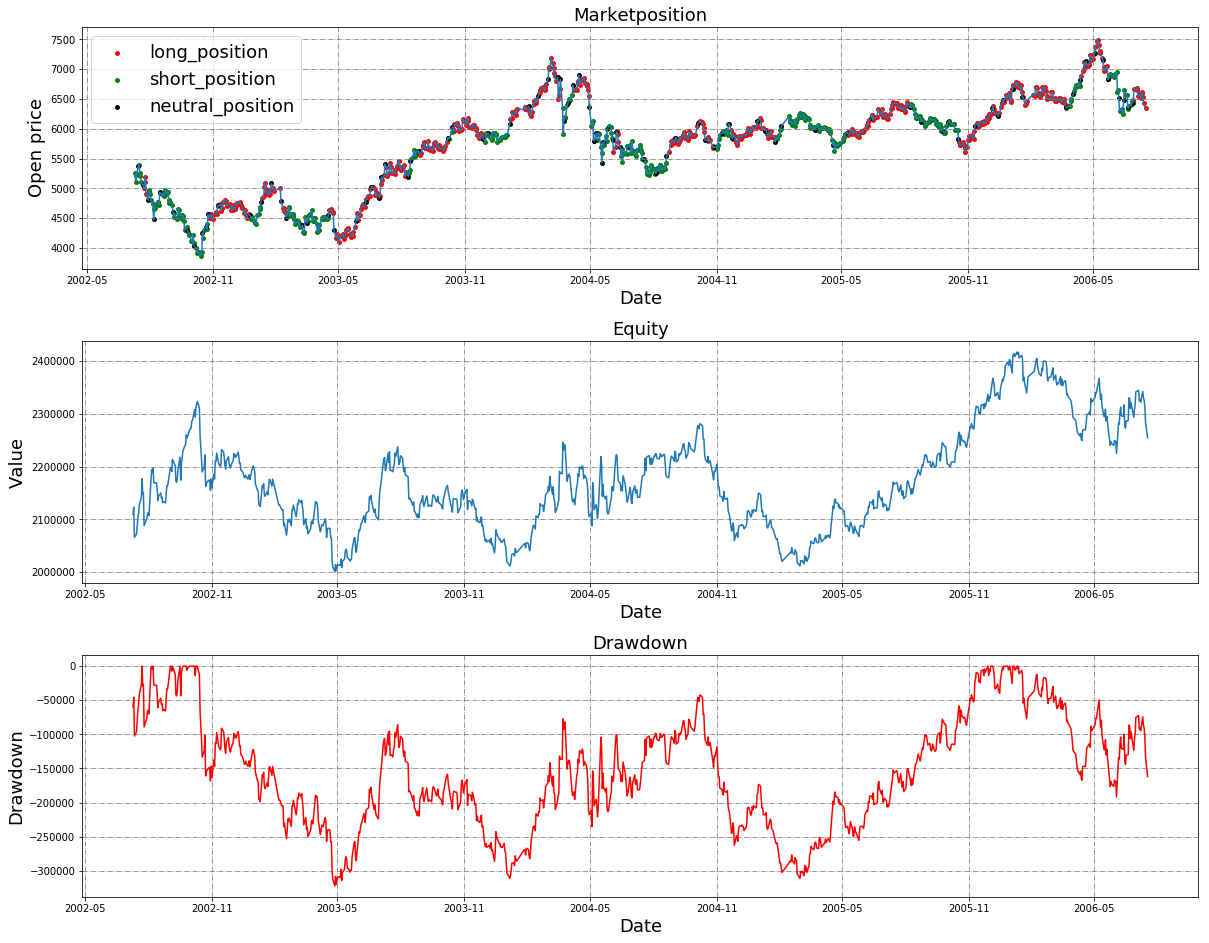

In [6]:
arg = [9,16,-30000,40000]

strategy_ma = strategy_MA(max_look_back = 30)
strategy_ma.set_para(*arg)

path = 'D:/Documents/ipython/data/backtest_sys/TXF1_day.csv'
env = backtest_sys(data_path = path, max_look_back = strategy_ma.max_look_back)

while env.step_counter < env.data_len:
    if len(strategy_ma.data) < strategy_ma.max_look_back: ##蒐集足夠的資料
        strategy_ma.get_data(data=env.get_state()) 
        env.step_counter += 1
    else:
        strategy_output = strategy_ma.core()
        env.step_operate(strategy_output)
        strategy_ma.get_data(data=env.get_state()) 
        env.step_counter += 1

print('Profit' ,env.total_value)

env.plot_info(1000, 2000)

## KD test 測試有step的情況 未完待續

In [7]:
class strategy_KD(object):
    def __init__(self, max_look_back):
        self.max_look_back = max_look_back
        self.data = deque(maxlen=self.max_look_back)
        
    def reset(self):
        self.data.clear()
  
    def get_data(self, data): # collect the data to build the strategy
        self.data.append(data)
        if len(self.data) == self.max_look_back:
            self.data_date = [self.data[i][0] for i in range(self.max_look_back-1,-1,-1)]
            self.data_open = [self.data[i][1] for i in range(self.max_look_back-1,-1,-1)]
            self.data_high = [self.data[i][2] for i in range(self.max_look_back-1,-1,-1)]
            self.data_low = [self.data[i][3] for i in range(self.max_look_back-1,-1,-1)]
            self.data_close = [self.data[i][4] for i in range(self.max_look_back-1,-1,-1)]
            self.data_vol = [self.data[i][5] for i in range(self.max_look_back-1,-1,-1)]
            self.marketposition = [self.data[i][6] for i in range(self.max_look_back-1,-1,-1)]
            self.openposition = [self.data[i][7] for i in range(self.max_look_back-1,-1,-1)]
        else:
            pass
        
    ################################### Build the strategy below ##################################
            
    def set_para(self, *arg):
        self.slen = int(arg[0])
        self.t = float(arg[1])
        self.loss_limit = int(arg[2])
        self.profit_limit = int(arg[3])
        
        self.para_describe = ['slen', 't', 'loss_limit', 'profit_limit']
        
        if self.max_look_back < self.slen:
            raise ValueError("max_look_back must be larger than all parameters of period")  
        if self.t > 1 or self.t < 0:
            raise ValueError("t must be between 0 and 1")  
        if self.loss_limit > 0:
            raise ValueError("loss_limit must be negative")  
        if self.profit_limit < 0:
            raise ValueError("profit_limit must be positive")    
            
    def core(self): 

        rsv = ((self.data_close[0] - min(self.data_low[:self.slen])) / (max(self.data_high[:self.slen]) - min(self.data_low[:self.slen]))) * 100
        
        try:
            self.k = t * rsv + (1-t) * self.k
            self.d = t * self.k + (1-t) * self.d
        except AttributeError: 
            self.k = 50
            self.d = 50
            self.k = t * rsv + (1-t) * self.k
            self.d = t * self.k + (1-t) * self.d 
            
        if self.marketposition[0] == 0:
            if self.k  > self.d:
                output = 'long'
            else:
                output = 'short'
        else:
            if self.openposition[0] < self.loss_limit or self.openposition[0] > self.profit_limit:
                output = 'close'
            else:
                output = 'keep'
        return output

In [8]:
strategy_kd = strategy_KD(max_look_back=15)

path = 'D:/Documents/ipython/data/backtest_sys/TXF1_day.csv'
env = backtest_sys(data_path = path, max_look_back = strategy_ma.max_look_back)

args = [(5,10), (0.1,0.9,0.1), -30000, 40000]
outcome = optimize(env, strategy_kd, args)

outcome

ValueError: 未完待續! 還要再新增處理有step的狀況